
Description: Plot polars and minimize time to travel for a given TWA/TWS.

Get polars CSV from here: <https://jieter.github.io/orc-data/site/>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.interpolate import interp1d
from scipy.optimize import minimize

%matplotlib inline

π = np.pi

# Choose constants
L = 10          # [nm] distance to end point
α = 120 * π/180  # [rad] true wind angle
TWS = '12'      # [kts] true wind speed

In [2]:
datafile = Path('./prospector.csv')
df = pd.read_csv(datafile, delimiter=';')
df = (df.rename({'twa/tws':'TWA'}, axis=1)
        .assign(TWA_deg=lambda x: x['TWA'],
                TWA_rad=lambda x: x['TWA_deg'] * π/180)
        .set_index('TWA_rad')
        .drop('TWA', axis=1)
        .sort_index()
        .replace(0, np.nan)
        )
df.columns.name = 'TWS'

print(df)

TWS           6      8     10     12     14     16     20  TWA_deg
TWA_rad                                                           
0.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN      NaN
0.621337    NaN    NaN    NaN    NaN    NaN    NaN  10.34     35.6
0.628319    NaN    NaN    NaN    NaN    NaN  10.20    NaN     36.0
0.642281    NaN    NaN    NaN    NaN  10.02    NaN    NaN     36.8
0.666716    NaN    NaN    NaN   9.85    NaN    NaN    NaN     38.2
0.694641    NaN    NaN   9.58    NaN    NaN    NaN    NaN     39.8
0.733038    NaN   9.08    NaN    NaN    NaN    NaN    NaN     42.0
0.771436   7.95    NaN    NaN    NaN    NaN    NaN    NaN     44.2
0.907571   8.88  10.15  10.68  11.01  11.30  11.64  12.08     52.0
1.047198   9.58  10.61  11.11  11.57  11.95  12.25  12.88     60.0
1.308997  10.18  11.19  11.94  12.56  13.05  13.46  14.32     75.0
1.570796  10.23  11.38  12.57  13.31  13.97  14.49  15.34     90.0
1.919862   9.58  10.78  11.84  13.12  14.46  15.46  17.28    1

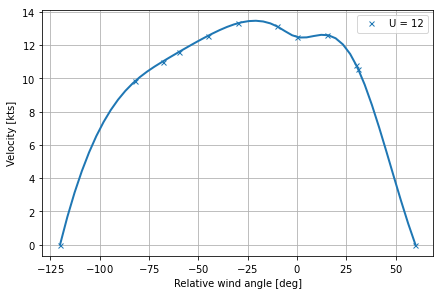

In [3]:
assert TWS in df.columns

# Fit a spline to the data
tf = df[TWS].dropna()
tf.at[0] = 0
tf.at[π] = 0

θ = np.linspace(tf.index.min(), tf.index.max())
V = interp1d(tf.index, tf, kind='cubic')

# Plot the data and spline fit
fig = plt.figure(1, clear=True, constrained_layout=True)
ax = fig.add_subplot()

ax.plot((θ - α) * 180/π, V(θ), 'C0-', zorder=1)  # line behind data
ax.plot((tf.index - α) * 180/π, tf.values, 'C0x', label=rf"U = {TWS}")

ax.set(xlabel='Relative wind angle [deg]',
       ylabel='Velocity [kts]')
ax.grid(True)
ax.legend()


In [4]:
class TrianglePath():
    """The triangle path object."""

    def __init__(self, θ, d, α=0, V=V, L=L):
        """
        Parameters
        ----------
        θ : float
            Starting angle.
        d : float
            Distance along starting angle. Must be ≤ L.
        α : float
            The true wind angle.
        V : callable, optional
            Velocity as a function of `θ`.
        """
        self.θ = θ
        self.d = d
        self.α = α
        self.V = V
        self.d_1 = (d**2 + L**2 - 2*d*L*np.cos(θ))**0.5  # law of cosines
        self.θ_1 = np.arccos((L - d*np.cos(θ)) / self.d_1)

    @property
    def total_distance(self):
        return self.d + self.d_1

    @property
    def time_0(self):
        return self.d / self.V(self.α - self.θ) 

    @property
    def time_1(self):
        return self.d_1 / self.V(self.α - self.θ_1) 

    @property
    def total_time(self):
        return self.time_0 + self.time_1

    @property
    def average_velocity(self):
        return self.total_distance / self.total_time

    # TODO define get/set methods to keep all consistent


# Define the objective function separately for fast evaluation
# TODO add cost of tack/gybe (function of turning angle?)
def time_to_point(θ, d, α=0, V=V, L=L):
    """Compute the time to traverse the triangle.

    Parameters
    ----------
    θ : float
        Starting angle.
    d : float
        Distance along starting angle. Must be ≤ L.
    α : float
        The true wind angle.
    V : callable, optional
        Velocity as a function of `θ`.

    Returns
    -------
    time : float
        The time in [hr] to traverse the edges of the triangle.
    """
    d_1 = (d**2 + L**2 - 2*d*L*np.cos(θ))**0.5  # law of cosines
    θ_1 = np.arccos((L - d*np.cos(θ)) / d_1)
    return d / V(α - θ) + d_1 / V(α - θ_1)


# Compute the angle and initial leg length for minimum time
res = minimize(lambda x: time_to_point(*x, α=α, V=V, L=L),
               x0=np.r_[1, 1],
               bounds=((0, π/2), (0, L)),
               )

# Compute the remaining parameters for convenience
tp = TrianglePath(*res.x, α=α, L=L, V=V)

print(f"Average speed is {tp.average_velocity - V(α):.2f} [kts] greater than straight-line.")
print(f"Time is {tp.total_time - L/V(α):.2f} [hr] faster than straight-line.")


Average speed is 0.77 [kts] greater than straight-line.
Time is -0.03 [hr] faster than straight-line.


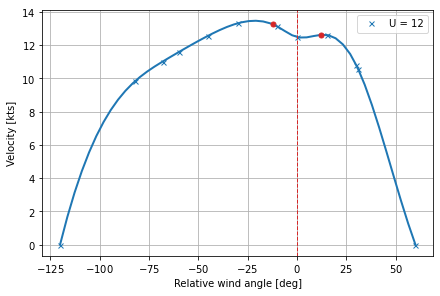

In [5]:

# Plot the two leg velocities
ax.axvline(0, c='C3', ls='--', lw=1)
ax.scatter(tp.θ * 180/π, V(α + tp.θ), c='C3', marker='o')
ax.scatter(-tp.θ_1 * 180/π, V(α - tp.θ_1), c='C3', marker='o')

fig